# 统计 new structural entropy

In [1]:
import pymongo
import matplotlib.pyplot as plt
import numpy as np
from dotenv import dotenv_values
import collections
import pandas as pd
from matplotlib.ticker import FuncFormatter

env_config = dotenv_values("../.env")

In [13]:
database_name = f"wikipedia_dump_v{env_config['WIKI_VERSION']}"
wikipedia_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_structural_entropy"]
wikipedia_entropy_collection.count_documents({})

66

In [15]:
start_year, end_year = 2004,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)


entropy_lv = {
    "big":np.full(end_year-start_year+1,np.nan),
    'little':np.full(end_year-start_year+1,np.nan),
    # 'delta':np.full(end_year-start_year+1,np.nan)
}
for lv in range(3,4):
    for doc in wikipedia_entropy_collection.find({'level':lv}):
        index = doc['year'] - start_year
        if index <= 0:
            continue
        entropy_lv['little'][index] = doc['entropy']['littleentropy']    
        entropy_lv['big'][index] = doc['entropy']['bigentropy']    
        
entropy_lv['delta'] = entropy_lv['big'] - entropy_lv['little']
df = pd.DataFrame(entropy_lv, index=year_range)

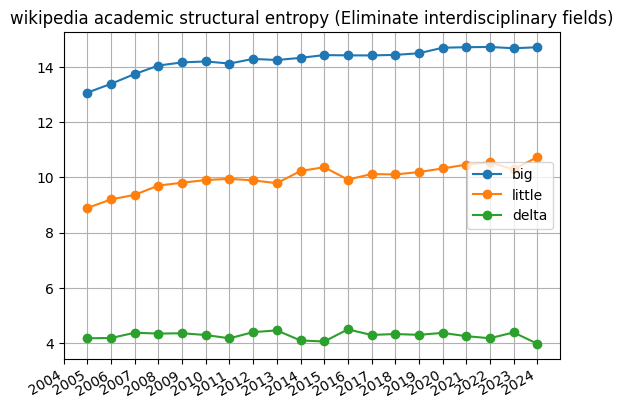

In [17]:
df.plot( marker='o')
# plt.xlim(start_year, end_year)
plt.title("wikipedia academic structural entropy (Eliminate interdisciplinary fields)")
plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()

# openalex

In [18]:
database_name = f"openalex_v{env_config['OPENALEX_VERSION']}"
openalex_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["new_structural_entropy"]
openalex_entropy_collection.count_documents({})

2039

In [41]:
start_year, end_year = 1940,2024
year_range = np.arange(start_year, end_year+1, dtype=np.int16)

entropy_data_list = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
entropy_data_list = collections.defaultdict(lambda :np.full(end_year-start_year+1,np.nan))
   
for doc in openalex_entropy_collection.find({ 'rankType':'current', 
                                             'startPercent':0, }):
    if isinstance(doc['entropy'],float):
        continue
    
    index = doc['year'] - start_year
    if index < 0:
        continue
    endPercent = doc['endPercent']
    if endPercent not in [10,40, 60,100]:
        continue
    
    key = f"top {endPercent}% big"
    entropy_data_list[key][index] = doc['entropy']['bigentropy']
    key = f"top {endPercent}% little"
    entropy_data_list[key][index] = doc['entropy']['littleentropy']
    key = f"top {endPercent}% delta"
    entropy_data_list[key][index] = doc['entropy']['bigentropy']- doc['entropy']['littleentropy']

len(entropy_data_list)

12

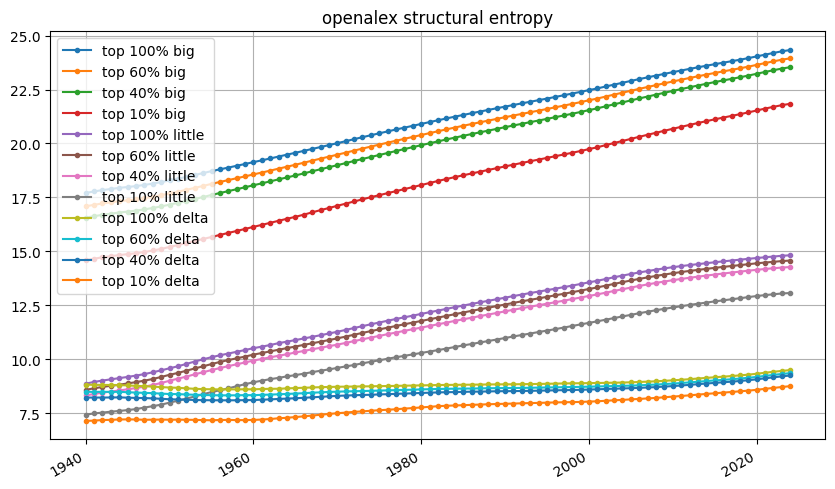

In [42]:
df = pd.DataFrame(entropy_data_list, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]

# plt.figure(figsize=(22, 10))  # 宽度为 10 英寸，高度为 6 英寸
df.plot(marker=".",figsize=(10, 6))
# plt.xlim(start_year, end_year)
plt.title("openalex structural entropy")
# plt.xticks(year_range)
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()